### Most ambiguous words in terms of in how many emojis they appear

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.notebook import tqdm
from scipy.stats import entropy
import gensim.models as gs

from settings import E2V_EMBEDDINGS, EMBEDDINGS_PATH, AMBIGUITY_PATH
from src.analysis.embedded import calculate_vocabulary_variation, embedded_CIs
from src.data.utils import parallelize_dataframe

pd.set_option('mode.chained_assignment', None)

sns.set(rc={'figure.figsize':(15, 7)}, font_scale=1.3)
sns.set_style("white", {'axes.grid' : False})

In [2]:
ambiguity = pd.read_csv(AMBIGUITY_PATH, encoding='utf-8')
ambiguity.head()

WorkerID  FormId  Duration  emoji_index emoji     word
0  A19AAMLW7OP5V4      65     330.0            0   #Ô∏è‚É£      ash
1  A1DD23J1WBGQUU      65     315.0            0   #Ô∏è‚É£  hashtag
2  A2C7A6E70NYNUI      65     317.0            0   #Ô∏è‚É£  hashtag
3  A2CK0OXMPOR9LE      65     521.0            0   #Ô∏è‚É£    pound
4  A272X64FOZFYLB      65     329.0            0   #Ô∏è‚É£    pound

In [3]:
words_by_num_emojis = ambiguity.groupby("word").emoji.nunique().reset_index().rename({"emoji":"num_emojis"}, axis=1)

### What is the most ambiguous word?

In [4]:
words_by_num_emojis.nlargest(n=20, columns='num_emojis')

word  num_emojis
1865    happy          69
4064   symbol          58
2374     love          43
2431      man          43
3410      sad          43
3738    smile          41
3646     sign          39
2288   letter          38
139     arrow          36
455       boy          34
234      ball          33
3878   square          32
3950     stop          32
1424   family          30
728   chinese          28
1571     food          27
1702     girl          26
450       box          25
2681       no          24
94      angry          23

In [5]:
words_by_num_emojis.describe()

num_emojis
count  4698.000000
mean      2.333333
std       3.424790
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max      69.000000

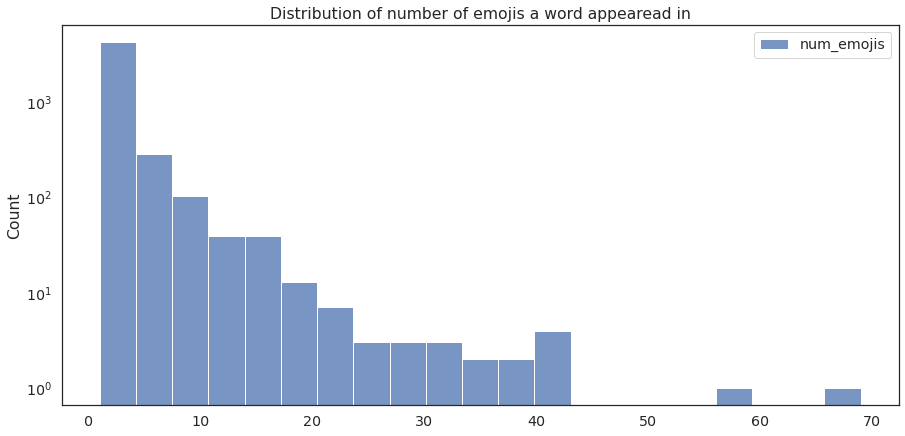

In [6]:
sns.histplot(words_by_num_emojis, log_scale=(False, True), bins='doane')\
        .set_title("Distribution of number of emojis a word appearead in");

In [7]:
words_by_num_emojis.sort_values(by="num_emojis")

word  num_emojis
0          TRUE           1
2299  librarian           1
2300    library           1
2301       lick           1
2302        lie           1
...         ...         ...
2431        man          43
2374       love          43
3410        sad          43
4064     symbol          58
1865      happy          69

[4698 rows x 2 columns]

#### Median words in terms of ambiguity

In [8]:
words_by_num_emojis[words_by_num_emojis.num_emojis.sub(words_by_num_emojis.num_emojis.median()).abs().lt(0.001)]

word  num_emojis
0              TRUE           1
2          aardvark           1
3                ab           1
4            abacus           1
5     abbreviations           1
...             ...         ...
4686            yum           1
4687          yummy           1
4688            zap           1
4692         zipped           1
4695    zodiccircle           1

[2879 rows x 2 columns]

#### Mean words in terms of ambiguity

In [9]:
words_by_num_emojis[words_by_num_emojis.num_emojis.sub(words_by_num_emojis.num_emojis.mean()).abs().lt(1)]

word  num_emojis
8           abcs           2
10         above           2
14    accessible           2
17           ace           3
20         acorn           2
...          ...         ...
4690        zero           2
4691      zigzag           2
4693      zipper           2
4696      zombie           2
4697         zoo           3

[1104 rows x 2 columns]

In [10]:
words_by_num_emojis.groupby("num_emojis").word.apply(set)

num_emojis
1     {stool, bunny face, sizzle, stormy, clothespin...
2     {yikes, lantern, knee, clam, stethoscope, test...
3     {sarcastic, check, send, ballet, safe, holiday...
4     {suspicious, driving, indian, insect, scale, s...
5     {gift, mountain, sweat, mute, angel, meditate,...
6     {globe, rewind, horse, plane, video, fun, vaca...
7     {men, stocks, reverse, left, mother, record, r...
8     {number, alarm, notepad, shirt, snowflake, pla...
9     {robot, caution, disappointed, alien, unhappy,...
10    {tired, annoyed, church, bread, flag, rock, pi...
11    {chart, mad, baby, text, sunshine, rain, turn,...
12    {tree, right, sunny, candy, fruit, peace, nerv...
13    {surprised, game, horoscope, blank, speaker, h...
14    {cross, thinking, shocked, kanji, down, book, ...
15    {up, note, worker, cry, astrology, cat, money,...
16    {person, bowl, confused, animal, ship, travel,...
17             {mail, work, water, zodiac, funny, hand}
18        {flower, worried, house, fi

In [11]:
ambiguity.word.nunique()

4698

In [12]:
words_em_voc = ambiguity.groupby("word").emoji.apply(list).apply(Counter).reset_index()
words_em_voc

word                                              emoji
0            TRUE                                          {'‚úåÔ∏è': 1}
1               a  {'‚õé': 1, 'üÖ∞Ô∏è': 16, 'üàÅ': 1, 'üàÇÔ∏è': 1, 'üéé': 1, 'üí¢...
2        aardvark                                           {'ü¶°': 1}
3              ab                                          {'üÜé': 10}
4          abacus                                          {'üßÆ': 13}
...           ...                                                ...
4693       zipper                                   {'üö†': 1, 'ü§ê': 1}
4694       zodiac  {'‚ôà': 1, '‚ôâ': 1, '‚ôä': 3, '‚ôå': 3, '‚ôç': 1, '‚ôé': ...
4695  zodiccircle                                          {'‚öõÔ∏è': 1}
4696       zombie                                  {'üßû': 1, 'üßü': 22}
4697          zoo                           {'üêõ': 1, 'ü¶í': 2, 'ü¶ß': 1}

[4698 rows x 2 columns]

In [13]:
words_em_voc['entropy'] = words_em_voc.emoji.apply(lambda x: entropy(list(x.values())))

In [14]:
words_em_voc.head()

word                                              emoji   entropy
0      TRUE                                          {'‚úåÔ∏è': 1}  0.000000
1         a  {'‚õé': 1, 'üÖ∞Ô∏è': 16, 'üàÅ': 1, 'üàÇÔ∏è': 1, 'üéé': 1, 'üí¢...  1.074614
2  aardvark                                           {'ü¶°': 1}  0.000000
3        ab                                          {'üÜé': 10}  0.000000
4    abacus                                          {'üßÆ': 13}  0.000000

In [15]:
pd.set_option('max_colwidth', 800)
words_em_voc.nlargest(10, 'entropy')[["word", "emoji"]]

word  \
4064  symbol   
1865   happy   
2374    love   
3646    sign   
2288  letter   
139    arrow   
1424  family   
2431     man   
3410     sad   
3738   smile   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        emoji  
4064                                                                                                    {'‚ìÇÔ∏è': 1, '‚ò¶Ô∏è': 1, '‚ò∏Ô∏è': 1, '‚ôà': 1, '‚ôâ': 4, '‚ôä': 1, '‚ôå': 1, '‚ôç': 2, '‚ôé': 1, '‚ôê': 1, '‚ôë': 3, '‚ôì': 3, '‚ôæÔ∏è': 1, '‚öïÔ∏è': 1, '‚öúÔ∏è': 3, '‚õé': 1, '‚ùáÔ∏è': 3, '‚ùï': 1, '‚ùó': 3, '‚û∞': 1, '‚ûø': 1, '‚¨ÜÔ∏è': 1, '„äóÔ∏è': 1, '„äôÔ∏è': 4, 'üÄÑ': 3, 'üÜî': 1, 'üàÅ': 1, 'üàÇÔ∏è': 6, 'üàö': 1, 'üàØ': 3, 'üà≤': 3, 'üà≥': 3, 'üà¥': 2, 'üàµ': 1, 'üà∂': 3, 'üà∑Ô∏è': 1, 'üà∏': 2, 'üàπ': 1, 'üà∫': 7, 'üâê': 1, 'üâë': 3, 'üç•': 1, 'üë®‚Äç‚ù§Ô∏è‚Äçüíã‚Äçüë®': 1, 'üí¢': 1, 'üí±': 1, 'üíπ': 4, 'üîÄ': 1, 'üîÑ': 1, 'üîö': 1, 'üî£': 2, 'üîØ': 1, 'üî±': 2, 'üïâÔ∏è': 5, 'üóΩ': 1, 'üö∑': 1, 'üõÉ': 1, 'üõë': 1, 'üõ°Ô∏è': 1}  
1865  {'‚ò∫Ô∏è': 9, 'üåö': 5, 'üåù': 8, 'üåû': 1, 'üéÖ': 1, 'üêµ': 1, 'üë¶': 3, 'üëß': 6, 'üë®‚Äçüíº': 1, 'üë®‚Äçü¶∞': 1, 'üë®‚Äçü¶±': 2, 'üë®‚Äçü¶≤': 7, 'üë©': 5, 'üë©‚Äç‚úàÔ∏è': 1, 'üë©‚Äçüåæ': 1, 'üë©‚Äçüë¶': 1, 'üë©‚ÄçüöÄ': 3, 'üë©‚Äçü¶∞': 5, 'üë©‚Äçü¶±': 1, 'üë©‚Äçü¶≤': 1, 'üë©‚Äçü¶≥': 2, 'üë™': 1, 'üë±': 3, 'üë≤': 1, 'üë≥': 1, 'üë¥': 1, 'üë∏': 1, 'üíï': 1, 'üòÄ': 15, 'üòÅ': 9, 'üòÉ': 14, 'üòÑ': 9, 'üòÖ': 1, 'üòÜ': 3, 'üòä': 12, 'üòã': 3, 'üòå': 5, 'üòé': 4, 'üòë': 1, 'üòô': 1, 'üòö': 1, 'üòõ': 3, 'üòú': 1, 'üòù': 1, 'üò¨': 1, 'üò∏': 5, 'üò∫': 2, 'üòª': 1, 'üôÇ': 11, 'üôÉ': 2, 'üôÖ': 1, 'üôÜ': 2, 'ü§ì': 3, 'ü§ó': 12, 'ü§†': 2, 'ü§°': 1, 'ü§§': 1, 'ü§©': 2, 'ü§∂': 1, 'ü§∏': 1, 'ü•∞': 2, 'ü¶ò': 1, 'ü¶∑': 1, 'üßë': 6, 'üßí': 3, 'üßì': 2, 'üßï': 2, 'üßñ': 3, 'üß∏': 1}  
2374                                                                                                                                                                                       {'‚ô•Ô∏è': 9, '‚ù£Ô∏è': 7, '‚ù§Ô∏è': 16, 'üå∏': 1, 'üåπ': 2, 'üëÑ': 1, 'üë®‚Äç‚ù§Ô∏è‚Äçüë®': 22, 'üë®‚Äç‚ù§Ô∏è‚Äçüíã‚Äçüë®': 15, 'üë©‚Äç‚ù§Ô∏è‚Äçüë®': 21, 'üë©‚Äç‚ù§Ô∏è‚Äçüë©': 13, 'üë©‚Äç‚ù§Ô∏è‚Äçüíã‚Äçüë®': 10, 'üë©‚Äç‚ù§Ô∏è‚Äçüíã‚Äçüë©': 13, 'üë¨': 2, 'üë≠': 1, 'üíå': 6, 'üíè': 15, 'üíë': 22, 'üíì': 11, 'üíï': 17, 'üíñ': 8, 'üíó': 9, 'üíò': 15, 'üíô': 12, 'üíö': 4, 'üíõ': 4, 'üíú': 10, 'üíù': 4, 'üíû': 18, 'üíü': 9, 'üñ§': 5, 'üòç': 20, 'üòó': 1, 'üòò': 4, 'üòö': 1, 'üòª': 25, 'üòΩ': 1, 'ü§ç': 5, 'ü§é': 11, 'ü§ò': 2, 'ü§ô': 1, 'ü§ü': 4, 'ü•∞': 19, 'üß°': 5}  
3646                                                                                                                                                                                                                                                                      {'¬ÆÔ∏è': 1, '‚èèÔ∏è': 2, '‚è∏Ô∏è': 1, '‚ò¶Ô∏è': 5, '‚ôâ': 2, '‚ôç': 1, '‚ôé': 3, '‚ôê': 1, '‚ôæÔ∏è': 1, '‚õé': 1, '‚ùáÔ∏è': 1, '‚ûø': 3, '‚¨ÜÔ∏è': 1, '„ÄΩÔ∏è': 2, 'üÄÑ': 1, 'üÜí': 2, 'üÜì': 1, 'üÜñ': 2, 'üàÇÔ∏è': 2, 'üàö': 1, 'üà∑Ô∏è': 2, 'üà∏': 5, 'üâë': 5, 'üéóÔ∏è': 1, 'üìë': 1, 'üìÆ': 1, 'üìµ': 1, 'üîÄ': 1, 'üîõ': 1, 'üöè': 6, 'üöß': 2, 'üö∑': 6, 'üö∏': 4, 'üöπ': 1, 'üö∫': 1, 'üöª': 1, 'üõÇ': 1, 'ü§ò': 1, 'üßè': 1}  
2288                                                                   

In [16]:
words_em_voc.nsmallest(10, 'entropy')

word      emoji  entropy
0            TRUE  {'‚úåÔ∏è': 1}      0.0
2        aardvark   {'ü¶°': 1}      0.0
3              ab  {'üÜé': 10}      0.0
4          abacus  {'üßÆ': 13}      0.0
5   abbreviations   {'üî£': 1}      0.0
6             abc   {'üî§': 3}      0.0
7            abcd   {'üî†': 2}      0.0
9             abe   {'üî§': 1}      0.0
11       abstract   {'‚ôí': 1}      0.0
12      accepting   {'ü§≤': 1}      0.0

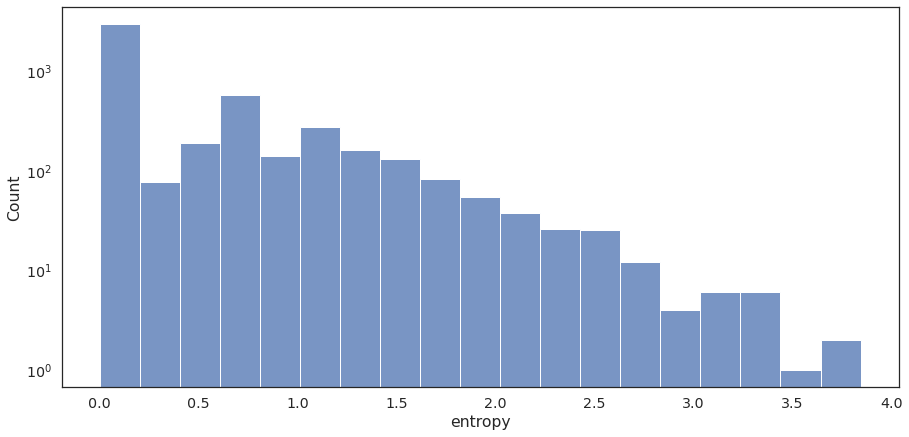

In [17]:
sns.histplot(data=words_em_voc.entropy, log_scale=(False, True), bins='doane');

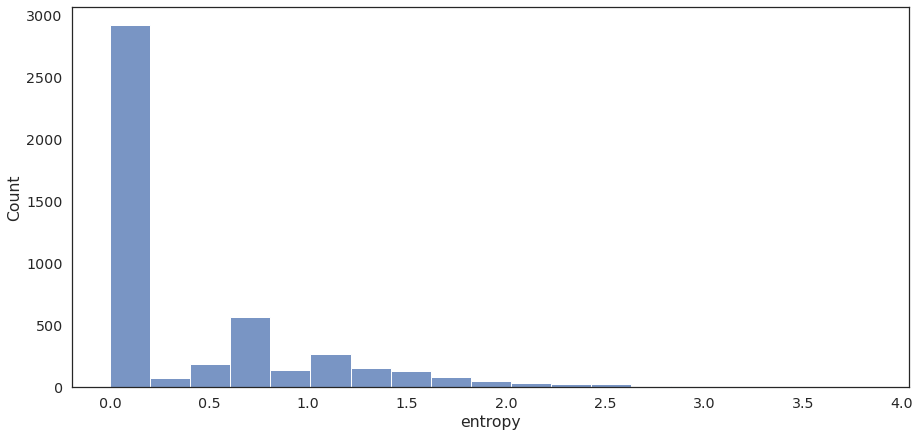

In [18]:
sns.histplot(data=words_em_voc.entropy, bins='doane');

### Variation in emoji space per word

In [25]:
e2v = gs.KeyedVectors.load_word2vec_format(E2V_EMBEDDINGS, binary=True)

In [26]:
calculate_vocabulary_variation(words_em_voc["emoji"].iloc[0], e2v)

0.0

In [27]:
happy = words_em_voc[words_em_voc.word == 'happy'].emoji.values[0]
calculate_vocabulary_variation(happy, e2v)

0.3088506073814577

In [28]:
words_em_voc['variation'] = words_em_voc.emoji.apply(lambda x: calculate_vocabulary_variation(x, e2v))

In [29]:
words_em_voc.nlargest(n=10, columns='variation')[['word', 'emoji', 'variation']]

word  \
4294  traveling   
648        cell   
409       board   
778       class   
884     contact   
512       build   
999         cup   
3674    sitting   
4257        toy   
1152    dislike   

                                                                            emoji  \
4294  {'‚õ¥Ô∏è': 1, '‚úàÔ∏è': 1, 'üöÅ': 1, 'üöÜ': 1, 'üöâ': 1, 'üöä': 1, 'üöó': 1, 'üöù': 1, 'üõ£Ô∏è': 1}   
648                              {'üàö': 1, 'üè®': 1, 'üìû': 1, 'üì≤': 1, 'ü§≥': 1, 'ü¶†': 1}   
409                            {'üàØ': 1, 'üë°': 1, 'üë©‚Äçüè´': 1, 'üîò': 1, 'üöß': 1, 'üõ∑': 1}   
778                                                    {'üçπ': 1, 'üë®‚Äçüè´': 1, 'üìù': 1}   
884                                             {'¬©Ô∏è': 1, 'üë§': 1, 'üë•': 1, 'üìá': 1}   
512                            {'üé¢': 1, 'üè¢': 1, 'üè™': 1, 'üìä': 1, 'üõ†Ô∏è': 1, 'üõ¢Ô∏è': 1}   
999                      {'‚åõ': 1, 'üç∂': 2, 'üèÜ': 3, 'üîã': 1, 'üîñ': 1, 'ü•£': 1, 'ü•§': 3}   
3674                                           {'üèÆ': 1, 'üë©‚Äçü¶Ω': 1, 'ü¶º': 1, 'ü™ë': 1}   
4257                   {'üéä': 1, 'üé†': 1, 'üë®‚Äçüöí': 1, 'ü§∑': 1, 'ü¶ß': 1, 'üßù': 1, 'üß∏': 1}   
1152                                             {'‚ö´': 1, 'üëÖ': 1, 'üëé': 1, 'üôÖ': 1}   

      variation  
4294   0.621276  
648    0.616001  
409    0.604323  
778    0.595540  
884    0.593228  
512    0.588517  
999    0.577000  
3674   0.570225  
4257   0.568961  
1152   0.565678

In [30]:
words_em_voc.nsmallest(n=10, columns='variation')

word      emoji  entropy  variation
0            TRUE  {'‚úåÔ∏è': 1}      0.0        0.0
2        aardvark   {'ü¶°': 1}      0.0        0.0
3              ab  {'üÜé': 10}      0.0        0.0
4          abacus  {'üßÆ': 13}      0.0        0.0
5   abbreviations   {'üî£': 1}      0.0        0.0
6             abc   {'üî§': 3}      0.0        0.0
7            abcd   {'üî†': 2}      0.0        0.0
9             abe   {'üî§': 1}      0.0        0.0
11       abstract   {'‚ôí': 1}      0.0        0.0
12      accepting   {'ü§≤': 1}      0.0        0.0

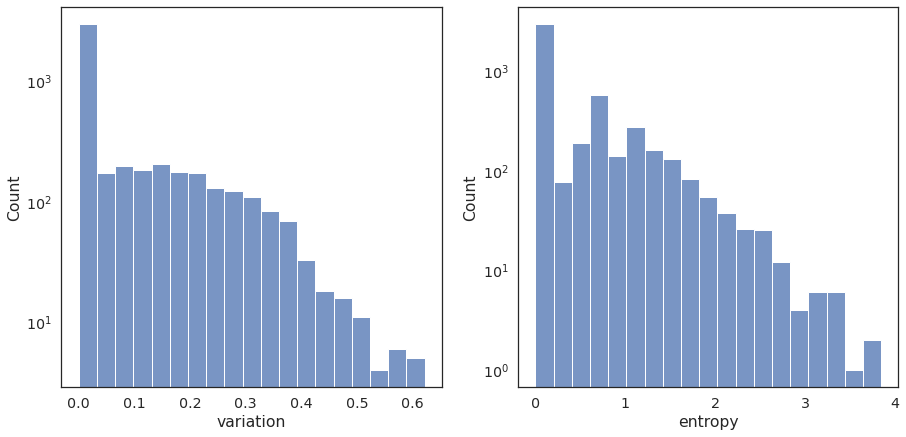

In [31]:
fig, axes = plt.subplots(1, 2)
sns.histplot(words_em_voc.variation, log_scale=(False, True), bins='doane', ax=axes[0]);
sns.histplot(words_em_voc.entropy, log_scale=(False, True), bins='doane', ax=axes[1]);

In [32]:
words_em_voc.describe()

entropy    variation
count  4698.000000  4698.000000
mean      0.401191     0.073183
std       0.616899     0.117377
min       0.000000     0.000000
25%       0.000000     0.000000
50%       0.000000     0.000000
75%       0.693147     0.129006
max       3.845106     0.621276

In [33]:
words_em_voc

word  \
0            TRUE   
1               a   
2        aardvark   
3              ab   
4          abacus   
...           ...   
4693       zipper   
4694       zodiac   
4695  zodiccircle   
4696       zombie   
4697          zoo   

                                                                                                                                         emoji  \
0                                                                                                                                    {'‚úåÔ∏è': 1}   
1                                                                                  {'‚õé': 1, 'üÖ∞Ô∏è': 16, 'üàÅ': 1, 'üàÇÔ∏è': 1, 'üéé': 1, 'üí¢': 1, 'üíØ': 1}   
2                                                                                                                                     {'ü¶°': 1}   
3                                                                                                                                    {'üÜé': 10}   
4                                                                                                                                    {'üßÆ': 13}   
...                                                                                                                                        ...   
4693                                                                                                                          {'üö†': 1, 'ü§ê': 1}   
4694  {'‚ôà': 1, '‚ôâ': 1, '‚ôä': 3, '‚ôå': 3, '‚ôç': 1, '‚ôé': 5, '‚ôè': 2, '‚ôê': 1, '‚ôë': 2, '‚ôí': 1, '‚ôì': 3, '‚õé': 1, '‚û∞': 1, '‚ûø': 1, 'üà∏': 1, 'üíπ': 1, 'üîØ': 1}   
4695                                                                                                                                 {'‚öõÔ∏è': 1}   
4696                                                                                                                         {'üßû': 1, 'üßü': 22}   
4697                                                                                                                  {'üêõ': 1, 'ü¶í': 2, 'ü¶ß': 1}   

       entropy  variation  
0     0.000000   0.000000  
1     1.074614   0.184354  
2     0.000000   0.000000  
3     0.000000   0.000000  
4     0.000000   0.000000  
...        ...        ...  
4693  0.693147   0.315452  
4694  2.653251   0.235861  
4695  0.000000   0.000000  
4696  0.178845   0.025469  
4697  1.039721   0.177611  

[4698 rows x 4 columns]

In [34]:
top_ten = words_em_voc.sort_values(by='variation', ascending=False)[:20]

In [35]:
top_ten.head()

word  \
4294  traveling   
648        cell   
409       board   
778       class   
884     contact   

                                                                            emoji  \
4294  {'‚õ¥Ô∏è': 1, '‚úàÔ∏è': 1, 'üöÅ': 1, 'üöÜ': 1, 'üöâ': 1, 'üöä': 1, 'üöó': 1, 'üöù': 1, 'üõ£Ô∏è': 1}   
648                              {'üàö': 1, 'üè®': 1, 'üìû': 1, 'üì≤': 1, 'ü§≥': 1, 'ü¶†': 1}   
409                            {'üàØ': 1, 'üë°': 1, 'üë©‚Äçüè´': 1, 'üîò': 1, 'üöß': 1, 'üõ∑': 1}   
778                                                    {'üçπ': 1, 'üë®‚Äçüè´': 1, 'üìù': 1}   
884                                             {'¬©Ô∏è': 1, 'üë§': 1, 'üë•': 1, 'üìá': 1}   

       entropy  variation  
4294  2.197225   0.621276  
648   1.791759   0.616001  
409   1.791759   0.604323  
778   1.098612   0.595540  
884   1.386294   0.593228

<AxesSubplot:xlabel='entropy', ylabel='variation'>

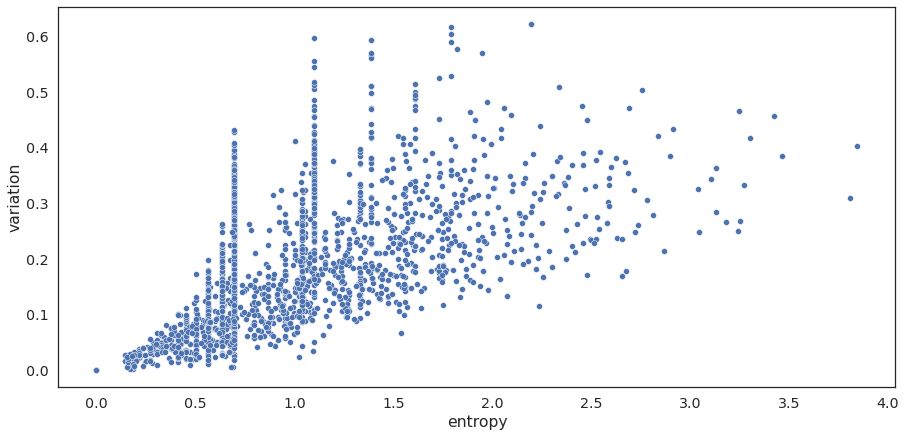

In [36]:
sns.scatterplot(data=words_em_voc, x='entropy', y='variation')

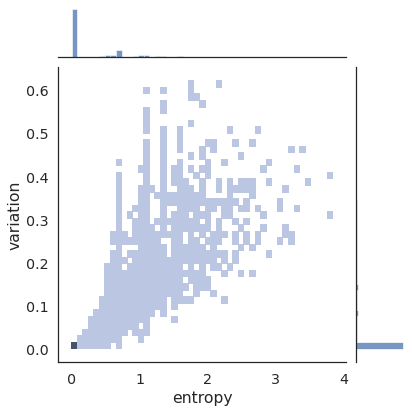

In [37]:
sns.jointplot(data=words_em_voc, x='entropy', y='variation', kind='hist')

In [38]:
print("Bootstrapping...")
func = lambda partial_df: partial_df.apply(lambda row: embedded_CIs(calculate_vocabulary_variation,
                                                                    row.emoji, e2v),
                                           axis=1)
CIs = parallelize_dataframe(top_ten, func)
top_ten["CIs"] = CIs

Bootstrapping...


  0%|          | 0/4 [00:00<?, ?it/s]

<BarContainer object of 20 artists>

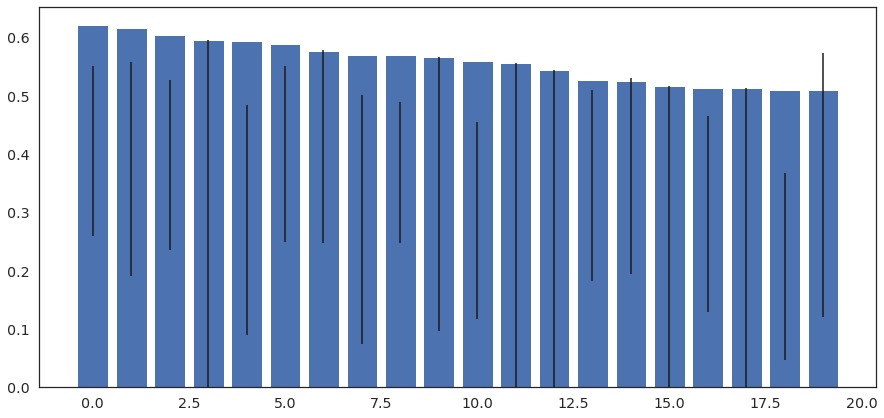

In [39]:
fig, ax = plt.subplots()

df = top_ten
col = 'variation'
CIs = np.array(df.CIs.to_list()).T
low = df[col].values - CIs[0, :]
high = CIs[1, :] - df['variation'].values
ax.bar(range(len(df.index)), df[col].to_list(), yerr=np.vstack((low, high)))